# Question: 

You belong to the data team at a local research hospital. You&#39;ve been tasked with
developing a means to help doctors diagnose breast cancer. You&#39;ve been given data
about biopsied breast cells; where it is benign (not harmful) or malignant (cancerous).
1. What features of a cell are the largest drivers of malignancy?
2. How would a physician use your product?
3. There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-efficient method of detecting malignancy?

In [1]:
## Question: You've been given data about biopsied breast cells; where it is benign (not harmful) or malignant (cancerous).


#import all required libraries

import os
import pandas as pd
import numpy as np

#visulization 
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib

import datetime

#data preprocessing

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
from scipy import stats
from scipy.stats import skew 
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
#from mlinsights.mlmodel import QuantileLinearRegression

#import xgboost
# from sklearn.ensemble import GradientBoostingRegressor
# from xgboost import XGBRegressor
# from sklearn.model_selection import KFold, cross_val_score

# Read Data and EDA Analysis:

In [2]:
#read data

# Input Training Dataset for the Model

def ReadFromCSV(FilePath, sckipLines = 0, sep = ','):  

    #Read and clean the csv file in FilePath ignoring the first sckipLines lines.

    #(omits non-ascii characters from columns' name)

    xa = pd.read_csv(FilePath, header=sckipLines, sep = sep, low_memory=False)

    return xa



In [3]:
df=ReadFromCSV('/Users/mojganmazouchi/Desktop/BreastCancer_dc/Copy of breast-cancer-wisconsin.txt') 
#df_all.shape  #(15,855, 12)

df=df.drop(['Index'],axis=1)
df.head()



,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1241035,7,8,3,7,4,5,7,8,2,4
1,1107684,6,10,5,5,4,10,6,10,1,4
2,691628,8,6,4,10,10,1,3,5,1,4
3,1226612,7,5,6,3,3,8,7,4,1,4
4,1142706,5,10,10,10,6,10,6,5,2,4


# Exploratory Data Analysis-- EDA

                 ID  Clump Thickness
count  1.585500e+04     15855.000000
mean   1.125972e+06         8.263198
std    9.957879e+05         7.393603
min    6.163400e+04         1.000000
25%    1.076352e+06         7.000000
50%    1.111249e+06         8.000000
75%    1.198641e+06        10.000000
max    1.345435e+07       100.000000
Class Distribution and Values: {'4': 15164, '2': 456, '40': 151, '?': 23, 'No idea': 17, '#': 11, '20': 5}
Class Distribution and Values: {'4': 15315, '2': 461, '?': 23, 'No idea': 17, '#': 11}
Class Distribution and Values: {'4': 15315, '2': 461, '0': 51}
[[<matplotlib.axes._subplots.AxesSubplot object at 0x10ed78748>


dtype('O')

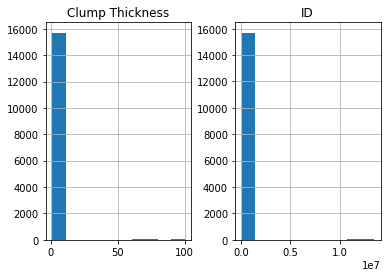

In [4]:
# Data Visualization:

df['Class'].describe()  #7 unique & top: 4 
#ax = sns.distplot(df['Class'])

print(df.describe())



#print ('Class Distribution and Values:', df['Class'].value_counts()) ## Data is Imbalance!!! 4 has 15164 observations and class 2 has 456 observations
print ('Class Distribution and Values:', df['Class'].value_counts().to_dict()) ## Data is Imbalance!!! 4 has 15164 observations and class 2 has 456 observations

df1=df.copy()
## I assumed the classes imported as 40 is 4 in another scale and 20 was suppose to be 2 so I converted them to 4 & 2

df1.Class.replace(['40', '20'], ['4', '2'], inplace=True)
print ('Class Distribution and Values:', df1['Class'].value_counts().to_dict()) ## Data is Imbalance!!! 4 has 15164 observations and class 2 has 456 observations

## I converted #, 'No idea', ? all to a category of Not available==0

df1.Class.replace(['#', 'No idea','?'], ['0', '0','0'], inplace=True)
print ('Class Distribution and Values:', df1['Class'].value_counts().to_dict()) ## Data is Imbalance!!! 4 has 15164 observations and class 2 has 456 observations

print (df1.hist())

df1['Class'].dtype

## Remove Duplicated Rows & Missing Values:

df1 with duplicates: (15855, 11)
df1 without duplicates: (754, 11)
                             Total   Percent
Class                           13  0.017241
Mitoses                         13  0.017241
Normal Nucleoli                 13  0.017241
Bland Chromatin                 13  0.017241
Bare Nuclei                     13  0.017241
Single Epithelial Cell Size     13  0.017241
Marginal Adhesion               13  0.017241
Uniformity of Cell Shape        13  0.017241
Uniformity of Cell Size         13  0.017241
Clump Thickness                  0  0.000000
(741, 11)
[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21ea25f8>


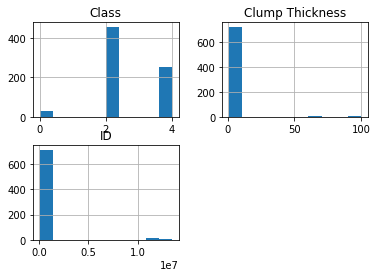

In [5]:
## Remove Duplicated Rows:
df1.groupby(df1.columns.tolist(),as_index=False).size() # check for duplicated rows & see how many records we have for each observations

print ('df1 with duplicates:', df1.shape) #(15855, 11)
df2=df1.drop_duplicates() 
print ('df1 without duplicates:', df2.shape)#(754, 11)



df3=df2.copy()
total =df3.isnull().sum().sort_values(ascending=False) # 28 missing values in all variables except the Clump Thickness
percent = (df3.isnull().sum()/df3.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print (missing_data.head(10))

#dealing with missing data by dropping cols with more than 25% missing values

#df3_nomiss= df3.drop((missing_data[missing_data['Percent'] > 0.25]).index,0) 
df3_nomiss=df3.dropna()
print (df3_nomiss.shape) #(741, 11) In non-duplicated dataset there is 13 missing values around 0.017241 among all

df3_nomiss['Class']=df3_nomiss['Class'].astype(int)
df3_nomiss['Class'].dtype
print (df3_nomiss.hist())



[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22aed6d8>


0     5
1    10
2     1
3     8
4    10
Name: Bare Nuclei, dtype: object

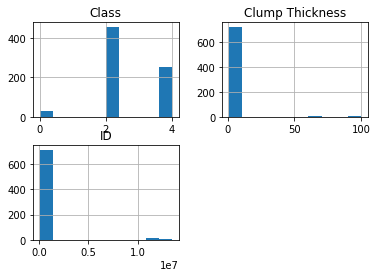

In [20]:
print (df3_nomiss.hist())
df4=df3_nomiss.copy()

df4 = df4[(df4["Uniformity of Cell Size"] != "No idea") & (df4["Uniformity of Cell Size"] != "#")& (df4["Uniformity of Cell Size"] != "?")]
#df4 = df4[(df4["Bare Nuclei"] != "No idea") & (df4["Bare Nuclei"] != "#")& (df4["Bare Nuclei"] != "?")]
df4['Bare Nuclei']=df4['Bare Nuclei'].replace('?', 0)
#df4['Bare Nuclei'] = df4['Bare Nuclei'].map({'?': 0})
#df4= df4[df4.applymap(np.isreal).all(1)]
# df4.applymap(lambda x: isinstance(x, (int, float)))
df4['Bare Nuclei'].head()

(710, 11)
[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2227abe0>


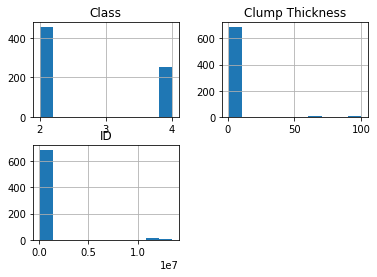

In [21]:
df4= df4[(df4["Class"] != 0)]
#print (df4.hist())
print(df4.shape) #(710, 11)
df4["Class"].describe()
print (df4.hist())



In [45]:
df4=df4.apply(pd.to_numeric)
df4.head(50)
df4.shape #(710, 11)
df4= df4.applymap(lambda x: x/10 if x > 10 else x)
df5=df4.copy()
df5.shape # 710,11
df5 = df5.drop('ID', 1)
df5.shape # 710, 10

(710, 10)

# Zero Variance Variables and Correlations

(710, 10)


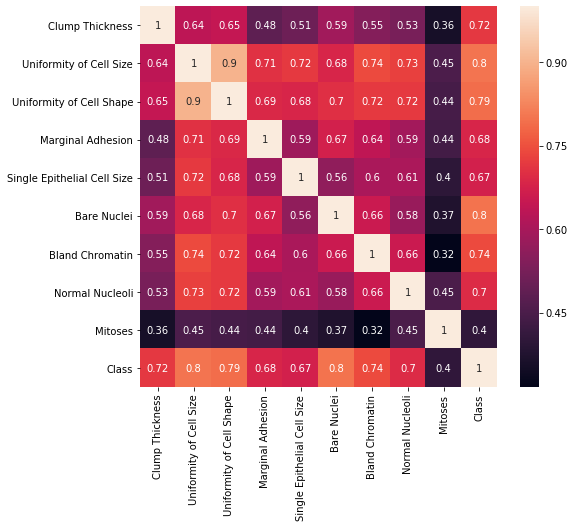

In [46]:

# Remove Zero Variance or Near Zero Variance Variables

df5=df5.loc[:, (df5 != df5.iloc[0]).any()] 
#df3_noncons=df3_nomiss.loc[:,df3_nomiss.apply(pd.Series.nunique) != 1] #remove cons vars
print (df5.shape) # No Constant variable found to drop


# Check for Correlations

#Correlation matrix (heatmap style)

corr1 = df5[df5.columns.values].corr()
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corr1, annot=True)




In [47]:
df5['Bare Nuclei'].describe()

count    710.000000
mean       3.583099
std        3.683263
min        0.000000
25%        1.000000
50%        1.000000
75%        7.000000
max       10.000000
Name: Bare Nuclei, dtype: float64

In [48]:
print ('Class Distribution and Values:', df5['Class'].value_counts().to_dict()) ## Data is Imbalance!!! 4 has 15164 observations and class 2 has 456 observations

Class Distribution and Values: {2: 456, 4: 254}


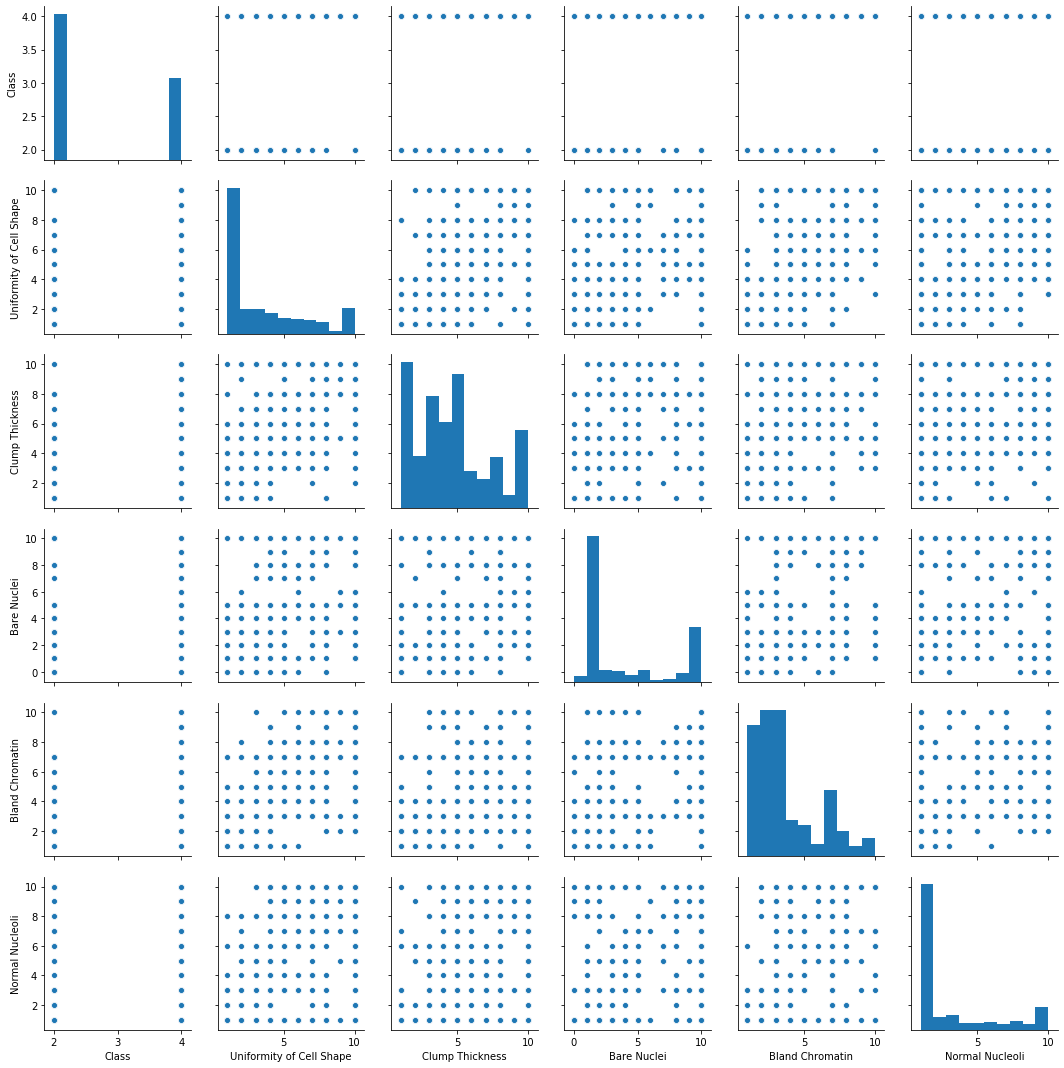

In [26]:
%config InlineBackend.figure_format = 'png'
ax = sns.pairplot(df5[['Class','Uniformity of Cell Shape', 'Clump Thickness','Bare Nuclei','Bland Chromatin','Normal Nucleoli']])

In [49]:
df5['Class']=df5['Class'].astype('category')
df5.shape

(710, 10)

# Over-sampling using SMOTE
 I over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

In [50]:
X = df5.loc[:, df5.columns != 'Class']
y = df5.loc[:, df5.columns == 'Class']

from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Class'])
# # we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['Class']==2]))
print("Number of subscription",len(os_data_y[os_data_y['Class']==4]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['Class']==2])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['Class']==4])/len(os_data_X))

length of oversampled data is  648
Number of no subscription in oversampled data 324
Number of subscription 324
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


# Recursive Feature Elimination
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [51]:
data_final_vars=df5.columns.values.tolist()
print (data_final_vars)
y=['Class']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']
[ True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1]


# Implementing the Model-Logistic Regression

In [73]:
import statsmodels.api as sm
y_tr=y_train.copy()
y_tr['Class']=y_train['Class'].replace([2, 4],[0, 1])
logit_model=sm.Logit(y_tr,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.431444
         Iterations 7
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.332     
Dependent Variable:     Class               AIC:                 446.8549  
Date:                   2019-07-02 18:35    BIC:                 484.7323  
No. Observations:       497                 Log-Likelihood:      -214.43   
Df Model:               8                   LL-Null:             -321.19   
Df Residuals:           488                 LLR p-value:         8.9836e-42
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         7.0000                                             
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Clump Thickness  

In [94]:
X=X_train.drop('Uniformity of Cell Shape',1)
X=X_train.drop('Marginal Adhesion',1)
os_data_y['Class']=os_data_y['Class'].replace(2,0)
os_data_y['Class']=os_data_y['Class'].replace(4,1)
y=os_data_y['Class']
logit_model=sm.Logit(y_tr,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.431898
         Iterations 7
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.332     
Dependent Variable:     Class               AIC:                 445.3071  
Date:                   2019-07-02 18:49    BIC:                 478.9758  
No. Observations:       497                 Log-Likelihood:      -214.65   
Df Model:               7                   LL-Null:             -321.19   
Df Residuals:           489                 LLR p-value:         1.9483e-42
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         7.0000                                             
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Clump Thickness  

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
# Use score method to get accuracy of model
score = logreg.score(X_test, y_test)
print(score)


[[127   5]
 [  4  77]]
0.9577464788732394


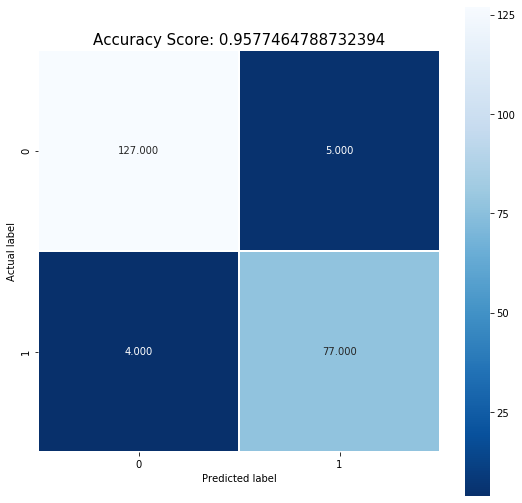

In [75]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);